# MMML Lab Assignment 2: SVM and optimization

The aim of this lab assignment is to implement the Support Vector Machines (SVM) classification algorithm. We will discuss 
*   the classical separating hyperplane (with hard margins)
*   separating hyperplane (with soft margins)
*   nonlinear separation (using kernels)  

and understand how the respective opitmization problems (including the dual Wolfe problem) can be solved numerically. Answering all questions will bring 7 points out of the total course grade.

Good sources on SVM algorithms are 

*   [Support Vector Machines Succintly](https://www.syncfusion.com/succinctly-free-ebooks/support-vector-machines-succinctly) an introductory explanation of all related questions
*   [The Elements of Statistical Learning](https://hastie.su.domains/Papers/ESLII.pdf) an advanced treatment of the linear and non-linear SVM





### Instructions 

1.   Form a team of two
2.   Rename the ipynb file to `Name1_Name2_MMML_Lab2.ipynb`
3.   Indicate team members at the top
4.   Change the number `blobs_random_seed` to the sum of your birthdays (i.e., day of the month)
5.   Provide your solutions (code or explanation) as necessary; do not reshuffle the cell order! You are welcome to optimize the existing commands if you want 
6.   Please execute all the cells before submission; make sure there are no errors, all plots have been generated, and all numerical answers calculated. Also, do not make *looong* prints
7.   Submit your notebook to **cms** along with the pdf output.  


## 1. Preparation and Data Generation **(0.25 pt)**

### 1.1 Import packages


In [1]:
# Imports
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from typing import List, Tuple

warnings.filterwarnings("ignore")

# fix seed for reproducible results
np.random.seed(0)
random.seed(0)

### 1.2 Fix configuration parameters

In [37]:
# Configuration options

# ========= YOUR CODE STARTS HERE ========= #
blobs_random_seed = 25
# ========== YOUR CODE ENDS HERE ========== #

centers = [(0,0), (5,5)]
cluster_std = 1
frac_test_split = 0.33
num_features_for_samples = 1
num_samples_total = 1000

### 1.3 Now we generate data, split for test/train datasets, and visualize the train dataset

The data are of the form $(\mathbf{x}_j,y_j)$, $j = 1,\dots, n$, where $\mathbf{x}_j \in \mathbb{R}^2$, and $y_j=1$ for red points and $y_j=-1$ for blue ones. 

In [3]:
# Generate data
def generate_data(num_samples_total: int, centers: List[Tuple[int, int]], num_features_for_samples: int, cluster_std: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    inputs, targets = make_blobs(n_samples = num_samples_total, centers = centers, n_features = num_features_for_samples, cluster_std = cluster_std)
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=frac_test_split, random_state=blobs_random_seed)
    y_train = 2*y_train -1
    y_test = 2*y_test-1
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = generate_data(num_samples_total, centers, num_features_for_samples, cluster_std)

In [4]:
# separate blue and red points for convenience
def split_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.float32]:
    red = X[np.where(y==1)]
    blue = X[np.where(y==-1)]
    # this is the direction vector to compare to 
    p = np.mean(red, axis = 0) - np.mean(blue, axis = 0)
    return red, blue, p

red, blue, p = split_data(X_train, y_train)

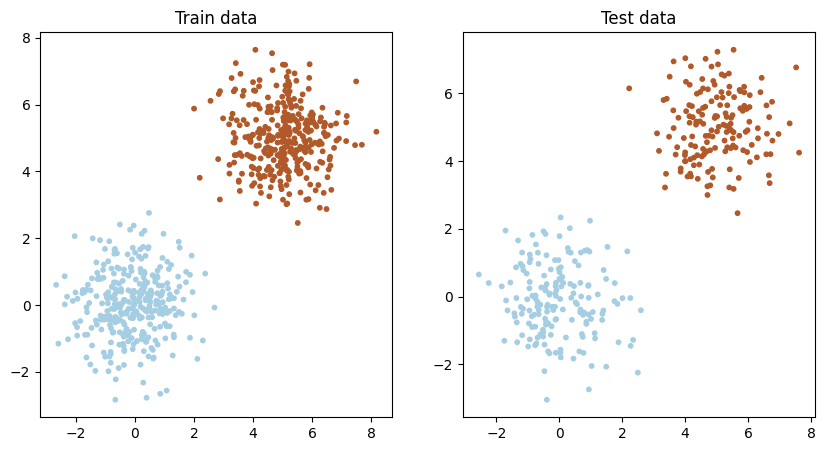

In [5]:
# Generate scatter plots for train and test data 
def plot_data(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
    plt.title("Train data")

    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap=plt.cm.Paired)
    plt.title("Test data")

    # plt.show()

plot_data(X_train, X_test, y_train, y_test)

### 1.4 Change the parameter `cluster_std` to 2 and regenerate the data.  

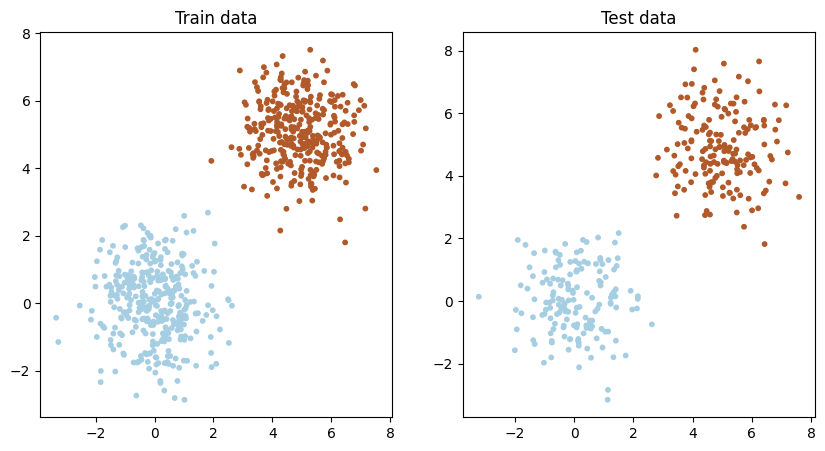

In [38]:
# ========= YOUR CODE STARTS HERE ========= #
# cluster_std = 2
X_train, X_test, y_train, y_test = generate_data(num_samples_total, centers, num_features_for_samples, cluster_std)
plot_data(X_train, X_test, y_train, y_test)
# ========== YOUR CODE ENDS HERE ========== #

#### **Question 1.1 (0.25 pt)**  

*   What do you think that parameter (`cluster_std`) is responsible for? What effect does it have on the data distribution?
---
Judging by the looks of the plotted data and the name of the variable, it would make sense that (`cluster_std`) would be responsible for the standard deviation within the clusters of points, i.e. in practice how likely are we to see them intersect. As we can see, for the regenerated data, they are no longer separable

---




### 1.5 We will use the values `cluster_std = 1` and  `cluster_std = 2` for the hard and soft margin classifiers

**Remark**: Decrease 1 in `cluster_std = 1` if necessary to get separable sets; increase 2 in `cluster_std = 2` to get non-separable sets

### 1.6 Visualization function

This is the function to visualize the optimal hyperplane and the margin


In [39]:
#  decision function
def decision_funct(x: np.ndarray, w: np.ndarray, b: np.float32) -> np.ndarray:
  return np.dot(x, w) + b   

#  visualization
def visualSVM(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: np.float32, support: List[int]):
  plt.scatter(X[:, 0], X[:, 1], c=y, s=10, alpha = .5, cmap=plt.cm.Paired)

  # plot the decision function
  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  # create grid to evaluate model
  xx = np.linspace(xlim[0], xlim[1], 30)
  yy = np.linspace(ylim[0], ylim[1], 30)
  YY, XX = np.meshgrid(yy, xx)
  xy = np.vstack([XX.ravel(), YY.ravel()]).T
  Z = decision_funct(xy, w, b).reshape(XX.shape)

  # plot decision boundary and margins
  ax.contour(
    XX, YY, Z, colors=['r', 'b', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
  )
  # plot support vectors
  ax.scatter(
    X[support, 0],
    X[support, 1],
    s=50,
    linewidth=1,
    facecolors="none",
    edgecolors="g",
  )

We run the visualization with the normal vector $\mathbf{w} = [1, -0.2]$,  free term $b = -3$, and the vectors $\mathbf{x}_0$ and $\mathbf{x}_{100}$ encircled. The hyperplane is not separating; try several other values to see the effect. 


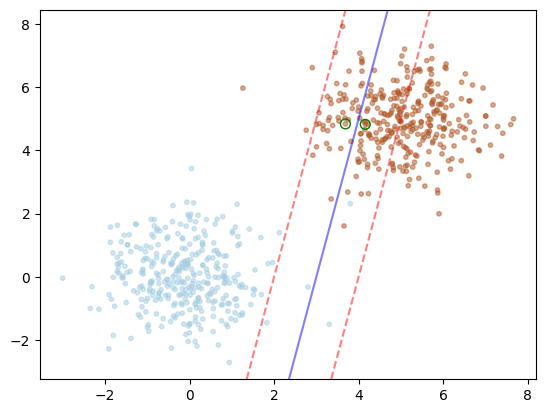

In [8]:
visualSVM(X_train, y_train, [1,-.2], -3, [0,100])

### 2.1: Choosing the optimal $b$ (0.5 pts)

For a given normal $\mathbf{w}\in\mathbb{R}^2$, find 
*   the optimal position of the separating hyperplane $H : \mathbf{x}\cdot\mathbf{w} + b = 0$
*   calculate the margin (or width) between classes. Margin is defined as distance between hyperplane and the observation (from each class), which is the closest to the hyperplane
*   rescale $\mathbf{w}$ and $b$ properly
*   visualize the separating hyperplane and the support vectors

The optimal separating hyperplane $$H:\quad \mathbf{x}\cdot\mathbf{w} + b = 0$$ with a fixed $\mathbf{w}$ is determined by $b = -(b_+ + b_-)/2$, where
$$b_+ = \min_{j:y_j = 1} \, (\mathbf{x}_j\cdot\mathbf{w}) \qquad \text{and} \qquad b_- = \max_{j:y_j = -1}\, (\mathbf{x}_j\cdot\mathbf{w})$$
and the margin (half-)width is 
$$ d = \text{(missing formula)} $$
The red points satisfying $\mathbf{x}_j\cdot\mathbf{w} = b_+$ and the blue points satisfying $\mathbf{x}_j\cdot\mathbf{w} = b_-$ are called __support vectors__ .To rephrase the formulas, these are points (from each class), which are the closest one to the separating hyperplane. 

**Remarks:**
*   Observe that the direction of the normal vector $\mathbf{w}$ should be chosen so that $\mathbf{p}\cdot \mathbf{w}>0$, where $\mathbf{p}$ is the vector connecting the centroids of the blue ($y_j = -1$) and red ($y_j = 1$) points; this guarantees that $b_+ > b_-$ for _optimal separating_ hyperplanes. However, the inequality $b_+ > b_-$ is not guaranteed even if $\mathbf{p}\cdot \mathbf{w}>0$; you should take this into account during scaling
*   After calculating $d$ for properly oriented $\mathbf{w}$, rescale $\mathbf{w}$ and $b$ so that $f(\mathbf{x}) = \pm1$ for support vectors


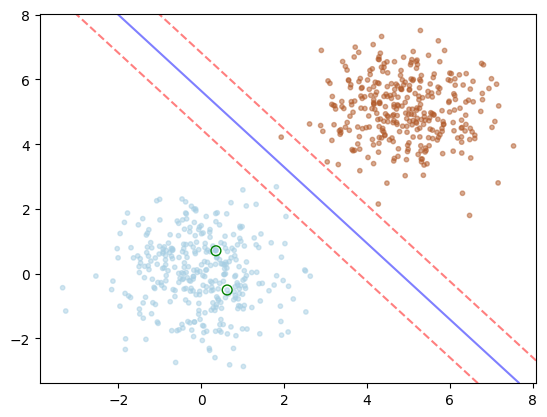

In [40]:
# ========= YOUR CODE STARTS HERE ========= #
visualSVM(X_train, y_train, [1,0.85], -4.8, [0,100])
# ========== YOUR CODE ENDS HERE ========== #


---
## 2. First task: Hard margin SVM classifier **(2.5 pts)** ##  

#### Given are the data $(\mathbf{x}_j,y_j)_{j=1}^n$ with $\mathbf{x}_j \in \mathbb{R}^2$ and $y_j = \pm 1$. The points $\mathbf{x}_j$ with $y_j=1$ are marked red and those with $y_j = -1$ blue. Under the assumption that red and blue points are linearly separable, the aim is to find the best ***linear classifier*** $f(\mathbf{x}) = \mathbf{x}\cdot\mathbf{w} + b$ such that $f(\mathbf{x})>0$ for red points and $f(\mathbf{x})<0$ for blue ones. We will determine $f$ using the training dataset and then evaluate its performance on the test dataset. 
---




    


#### **Question 2.1 (0.25 pt)**  

*   Write down the formula for $d$
---
$$ d = \frac{2}{\|\mathbf{w}\|}$$

---


---
#### **Question 2.2 (0.25 pt)**  

*   Implement the function below:
---

In [41]:
def optimal_b(X_train: np.ndarray, y_train: np.ndarray, w: np.ndarray, epsilon: np.float32 = 1e-3) -> Tuple[np.float32, np.ndarray, np.float32, np.ndarray]:
  # ========= YOUR CODE STARTS HERE ========= #
  # get red/blue labels
  red, blue, p = split_data(X_train, y_train)

  # check if w is properly oriented 
  w = w if np.dot(p, w) > 0 else -w
      
  # calculate b_red and the corresponding support vectors
  b_red = np.min(np.dot(red, w))
  # these are indices of the red support vectors; we allowed tolerance epsilon
  sprt_red = np.where((np.dot(X_train, w) <= b_red + epsilon) & (y_train == 1) )
  
  # calculate b_blue and the corresponding support vectors 
  b_blue = np.max(np.dot(blue, w))
  sprt_blue = np.where((np.dot(X_train, w) >= b_blue - epsilon) & (y_train == -1) )
  # print(sprt_red, sprt_blue)
  
  # concatenate the support lists 
  sprt = np.hstack((sprt_red, sprt_blue))

  # calculate the actual width of the separating slab
  b = -(b_red + b_blue) / 2
  d = min(b + b_red, b_blue - b)

  # the proper scaling factor for w and b
  sc_fact = d
  w = w / sc_fact   # rescale w
  b = b / sc_fact  # rescale b

  # ========== YOUR CODE ENDS HERE ========== #
  return d, w, b, sprt


[[370 349]]


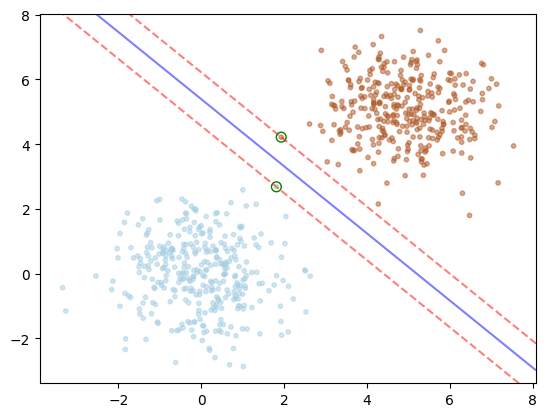

In [42]:
### Test the performance of the function by choosing w = p
_, w, b, sprt = optimal_b(X_train, y_train, w=p)
print(sprt)
visualSVM(X_train, y_train, w, b, sprt)

### 2.2: The Perceptron Learning Algorithm (PLA) **(0.75 pts)**

PLA is an iterative algorithm that updates the direction vector $\mathbf{w}$ towards a misclassified example, one at a time. 

To explain the idea, let's first augment vectors $\mathbf{x} = (x_1,x_2)^\top \in \mathbb{R}^2$ to $\hat{\mathbf{x}} = (1,x_1,x_2)^\top \in \mathbb{R}^3$ and $\mathbf{w} = (w_1,w_2)^\top$ to $\hat{\mathbf{w}} = (b ,w_1, w_2)^\top$; then the hyperplane  $H: \mathbf{w} \cdot \mathbf{x} + b = 0$ can be written as $\hat{\mathbf{w}}\cdot \hat{\mathbf{x}} = 0$. Therefore, correctly classified vectors $\mathbf{x}_j$ must satisfy the inequality 
$$
  y_j (\hat{\mathbf{w}}\cdot \hat{\mathbf{x}}_j) > 0.
$$
If $\mathbf{x}_j$ is a ''red'' point (with $y_j = 1$) that is misclassified, then the angle between $\hat{\mathbf{w}}$ and $\hat{\mathbf{x}}_j$ is obtuse. The idea is that we should decrease the angle between them by updating $\hat{\mathbf{w}}$ to $\hat{\mathbf{w}} + \hat{\mathbf{x}}_j$ (see Fig. 1). Likewise, if $\mathbf{x}_j$ is a misclassified ''blue'' point (with $y_j = -1$), then the angle between $\hat{\mathbf{w}}$ and $\hat{\mathbf{x}}_j$ is acute, and we increase it be replacing $\hat{\mathbf{w}}$ with $\hat{\mathbf{w}} - \hat{\mathbf{x}}_j$. 

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <img src="https://drive.google.com/uc?export=view&id=12rduejeedS8NxrxXkSBJkkcDH3lB0k-R">

</body>
</html>

This suggests the following classical **PLA**:
1.   Start with $\hat{\mathbf{w}}$ and classify the points
2.   Randomly select one of the misclassified points
3.   Update the $\hat{\mathbf{w}}$ and update classification
4.   Repeat 2 and 3 until there are misclassified points. 

It is proved that the PLA stops in a final number of steps if the data are linearly separable.

For large datasets, forming a list of misclassified points is a costly operation, so one makes such a list, iterates through it, updates $\hat{\mathbf{w}}$ whenever needed, and only then forms the list of miscallified points afresh. 


#### **Question 2.3 (0.25 pt): Analyze the PLA update step** 
Prove that by updating $\hat{\mathbf{w}}$, we are decreasing or increasing (as required) the angle between $\hat{\mathbf{w}}$ and $\hat{\mathbf{x}}_j$.

---
Let's say that for an arbitrary point $\mathbf{x_j}$, the dot product gives us an obtuse angle:
$$ 
p = \hat{\mathbf{w}}\cdot \hat{\mathbf{x}}_j = b + x_{1j}w_1 + x_{2j}w_2 \lt 0
$$
If we update $\hat{\mathbf{w}}$ by adding $\hat{\mathbf{x}}_j$, then the dot product will increase:
$$
p' = \hat{\mathbf{w'}}\cdot \hat{\mathbf{x}}_j = b + x_{1j}(w_1 + x_{1j}) + x_{2j}(w_2 + x_{2j}) = p + x_{1j}^2 + x_{2j}^2 \ge p
$$
Giving us an angle closer to an acute one. The inverse is true if our angle is acute to begin with, and we update $\hat{\mathbf{w}}$ by subtracting $\hat{\mathbf{x}}_j$.

Thus, to make an angle between a misclassified point and the normal vector closer to what we expect it to be, we update the normal vector by adding or subtracting the misclassified point, depending on which class it was supposed to be.

---
#### **Question 2.4 (0.25 pt)**  

*   Implement the functions below
---

In [43]:
#  The PLA algorithm
def misclassified(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: np.ndarray) -> np.ndarray:
  # ========= YOUR CODE STARTS HERE ========= #
  misclass = np.where(y * (np.dot(X, w) + b) <= 0)
  # ========== YOUR CODE ENDS HERE ========== #
  return misclass


def PLA(X_train: np.ndarray, y_train: np.ndarray, num_step: int = 1000) -> Tuple[np.float32, np.ndarray, np.float32]:
  # ========= YOUR CODE STARTS HERE ========= #
  # Initiate a hyperplane (45 degrees)
  w_initial = -np.array([1., 0.])
  b_initial = 0.
  _, w_initial, b_initial, _ = optimal_b(X_train, y_train, w_initial)

  # find initial misclassified points
  misclass =  misclassified(X_train, y_train, w_initial, b_initial)[0]
  # print(misclass)
  print("Initial no. of misclassified points:", len(misclass))
  
  # implement training loop
  step = 0
  b = b_initial
  w = w_initial
  while len(misclass)!=0 and step < num_step:
    step += 1
    # update the normal w of the hyperplane and b: 
    rand_point = random.choice(misclass)
    # print(rand_point)
    if y_train[rand_point] == 1:
      w += X_train[rand_point]
      b += 1
    else:
      w -= X_train[rand_point]
      b -= 1

    _, w, b, _ = optimal_b(X_train, y_train, w)
    # recalculate misclassified set
    misclass = misclassified(X_train, y_train, w, b)[0]
  
  # calculate final optimal parameters and margin
  d, w, b, sprt = optimal_b(X_train, y_train, w)
  misclass = misclassified(X_train, y_train, w, b)
  # ========== YOUR CODE ENDS HERE ========== #
  
  print("Number of steps required:", step)
  print("The margin is:", d, "\tw=", w, "\tb=", b)
  print("Final no. of misclassified points:", len(misclass))

  # calculate initial parameters for visualization
  _, w_initial, b_initial, _ = optimal_b(X_train, y_train, w_initial)
  misclass_initial =  misclassified(X_train, y_train, w_initial, b_initial)
  
  plt.figure(figsize=(10,5))

  plt.subplot(1, 2, 1)
  visualSVM(X_train, y_train, w_initial, b_initial, misclass_initial) 
  plt.title("Initial hyperplane")
  

  plt.subplot(1, 2, 2)
  visualSVM(X_train, y_train, w, b, sprt) 
  plt.title("final separating hyperplane")
  
  plt.show()
  return (d, w, b)

Initial no. of misclassified points: 665
Number of steps required: 2
The margin is: 1.0 	w= [1.42706518 2.83673905] 	b= -11.204053552531846
Final no. of misclassified points: 1


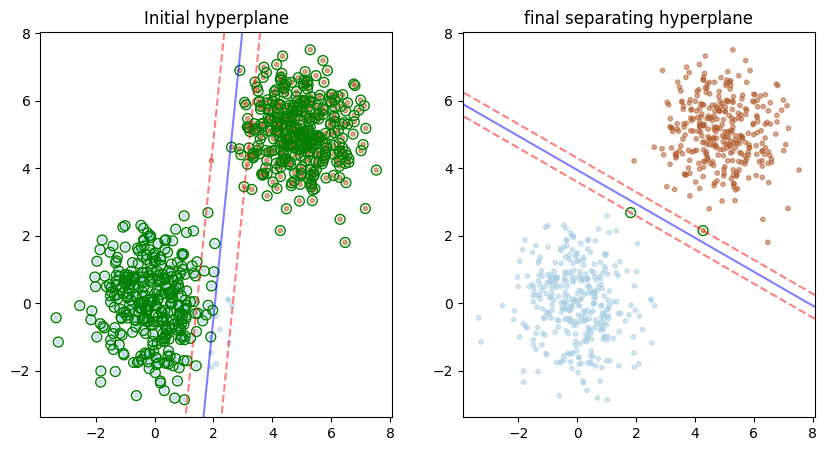

In [44]:
d, w_pla, b_pla = PLA(X_train, y_train)

#### Evaluate the accuracy of PLA:



In [45]:
# ========= YOUR CODE STARTS HERE ========= #
acc = (np.sum(y_test * decision_funct(X_test, w_pla, b_pla) > 0) / y_test.shape)[0]
print("The accuracy of PLA is", acc)
# ========== YOUR CODE ENDS HERE ========== #

The accuracy of PLA is 1.0



#### **Question 2.5 (0.25pt): Discuss pros and cons of the PLA**

PLA is a good method for perfectly separable data, however for non-separable data, it will not converge. Also, it does not optimize the margin at all, just ending up with any separating hyperplane from a set of possible ones, thus finding a valid, though suboptimal solution.






### 2.3: Direct maximization of the margin **(0.25 pt)**

Maximize the margin over the directions of $\mathbf{w} = (\cos\phi, \sin\phi)^\top$, find the best separating hyperplane and evaluate its performance on the test dataset


Run through all directions $\phi \in [0,\pi)$ and 
*   find the optimal direction of the separating hyperplane
*   the optimal position (parameter $b$) of the separating hyperplane $H : \mathbf{x}\cdot\mathbf{w} + b = 0$
*   visualize the separating hyperplane and the support vectors
*   calculate the margin (width)


---
#### **Question 2.6 (0.25 pt)**  

*   Implement the function below
---

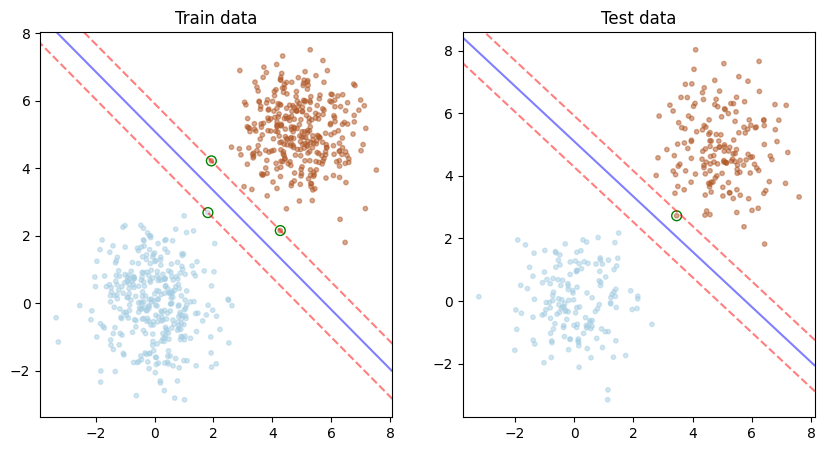

The margin is: 0.6135323106193518 	optimal w is: [1.07787618 1.22261054] 	optimal b is: -6.237245515528487


In [46]:
def direct_optimization(X_train: np.ndarray, y_train: np.ndarray, n: int = 1000) -> Tuple[np.float32, np.ndarray, np.float32]:
  # ========= YOUR CODE STARTS HERE ========= #
  max_d = float("-inf")
  for i in range(n):
    phi = i*np.pi/n 
    w = np.array([np.cos(phi), np.sin(phi)])
    d, w, b, sprt = optimal_b(X_train, y_train, w)
    # compare the current d with current maximum and update if necessary; save the optimal angle in phi_opt
    if d > max_d:
      max_d = d
      phi_opt = phi

  # calculate final optimal parameters and margin
  w_opt = np.array([np.cos(phi_opt), np.sin(phi_opt)])
  d_opt, w_opt, b_opt, sprt = optimal_b(X_train, y_train, w_opt)
  # ========== YOUR CODE ENDS HERE ========== #

  # illustrate decision for train and test data 
  plt.figure(figsize=(10,5))

  plt.subplot(1, 2, 1)
  sprt = np.where(y_train * decision_funct(X_train, w_opt, b_opt) < 1.01)[0]
  visualSVM(X_train, y_train, w_opt, b_opt, sprt)
  plt.title("Train data")

  plt.subplot(1, 2, 2)
  sprt = np.where(y_test * decision_funct(X_test, w_opt, b_opt) < 1.01)[0]
  visualSVM(X_test, y_test, w_opt, b_opt, sprt)
  plt.title("Test data")

  plt.show()

  return (d_opt, w_opt, b_opt)
  

d_opt, w_opt, b_opt = direct_optimization(X_train, y_train)
print("The margin is:", d_opt, "\toptimal w is:", w_opt, "\toptimal b is:", b_opt)

#### Evaluate the optimal classifier on the test set:




In [47]:
# ========= YOUR CODE STARTS HERE ========= #
acc = (np.sum(y_test * decision_funct(X_test, w_opt, b_opt) > 0) / y_test.shape)[0]
print("The accuracy of direct optimization is", acc)
# ========== YOUR CODE ENDS HERE ========== #

The accuracy of direct optimization is 1.0


### 2.4 SVM as an optimization problem and dual Wolfe problem **(1 pts)**


#### 2.4.1 Optimization problem
Let $f(\mathbf{x}) = \mathbf{x}\cdot \mathbf{w} + b$ be a linear classifier predicting the response variable $y$ via
$$
  y = \operatorname{sign}(f(\mathbf{x}))
$$

The task is to maximize the margin, i.e., the value $M$ s.t., for all $j$,
$$
   y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge M \|\mathbf{w}\|
$$
By rescaling $\mathbf{w}$ (and $b$) so that $M\cdot\|\mathbf{w}\| = 1$, we get an equivalent problem 
\begin{align*}
\operatorname{argmin}_{\mathbf{w}, b}  &\frac12 \|\mathbf{w}\|^2 \\
\text{subject to } \qquad &y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge 1
\end{align*}

The Lagrange function is 
$$
  \mathscr{L}(\mathbf{w}, b, \lambda) = \frac12\|\mathbf{w}\|^2 + \sum_j \lambda_j  [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)]
$$
Partial derivatives in $\mathbf{w}$ and $b$ give the equalities 
$$
    \mathbf{w} = \sum_j \lambda_j y_j \mathbf{x}_j \qquad \text{and} \qquad 0 = \sum_j \lambda_j y_j; \tag{1}
$$
and the slackness conditions (3) below for every $j$.

We now use these expressions in $\mathscr{L}$ to get the Wolfe dual problem of maximizing the quadratic problem
\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \mathbf{x}_j\cdot\mathbf{x}_k \tag{2}
\end{equation}
subject to the constraints $\lambda_j \ge 0$ and the slackness conditions that should be satisfied for every $j$:  
$$
   \lambda_j [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)] = 0 \tag{3}
$$
Recall that the indices $j$ for which $y_j(\mathbf{x}_j\cdot \mathbf{w} + b) = 1$ correspond to *support vectors* (i.e., points on the margin boundary). 

#### 2.4.2 Sequential Minimal Optimization
The Wolfe dual problem can be solved by applying the so called Sequential Minimal Optimization (SMO) method. The idea is to update only two (randomly chosen) Lagrange multipliers a time, say $\lambda_i$ and $\lambda_j$, in such a way that the constraint condition $\sum_k \lambda_ky_k = 0$ is preserved, the updated lambda's are non-negative, and the value of the function increases. 

To this end, we calculate the partial derivatives of $\mathscr{L}$ in $\lambda_i$ and $\lambda_j$, form the partial gradient $\mathbf{g}_{i,j}$, and move along the constraint line $\ell = \lambda_i y_i + \lambda_j y_j = \mathrm{const}$ to increase the value of $\mathscr{L}_D$. If the direction vector $\mathbf{d}:=(y_j, -y_i)$ of $\ell$ forms an acute angle with $\mathbf{g}_{i,j}$, we update the two lambda's in that direction; otherwise, in the opposite. The simplest implementation uses a constant learning rate.

--- 
#### **Question 2.7 (0.75 pts)**  

*   Implement the functions below
---

In [48]:
# calculate the partial derivative in lambda_j and fill in the missing line
def partial_derivative(X: np.ndarray, y:np.ndarray, lmbda: np.ndarray, j: int) -> np.float32:
  # ========= YOUR CODE STARTS HERE ========= #
  grad = 1 - np.sum(lmbda * y[j] * y * np.dot(X, X[j]))
  # ========== YOUR CODE ENDS HERE ========== #
  return grad

In [49]:
# complete the update rule for lambda_i and lambda_j
def dualSVM_SMO(X: np.ndarray, y: np.ndarray, lr: float = 1e-3, n_steps: int = 100000) -> np.ndarray:
  lmbda = np.zeros(X.shape[0])
  for k in range(n_steps):
    # ========= YOUR CODE STARTS HERE ========= #
    i, j = random.randint(0, X.shape[0]-1), random.randint(0, X.shape[0]-1)
    while y[i] == y[j]:
      j = random.randint(0, X.shape[0]-1)

    grad_i = partial_derivative(X, y, lmbda, i)
    grad_j = partial_derivative(X, y, lmbda, j)
    
    line_grad = np.fromiter([y[j], -y[i]], dtype=np.float64)
    part_grad = np.fromiter([grad_i, grad_j], dtype=np.float64)
    proj = np.dot(line_grad, part_grad) / np.linalg.norm(line_grad) ** 2 * line_grad

    if np.dot(part_grad, line_grad) < 0:
      proj = -proj

    lmbda_i = lmbda[i]
    lmbda_j = lmbda[j]
    lmbda[i] += lr * proj[0]
    lmbda[j] += lr * proj[1]

    if lmbda[i] < 0 or lmbda[j] < 0 or np.abs(np.dot(lmbda, y)) > 1e-3:
      lmbda[i] = lmbda_i
      lmbda[j] = lmbda_j
      print("KKT constraint failed")
    else:
      print(lmbda[i], lmbda[j])
    # ========== YOUR CODE ENDS HERE ========== #

  print("no. of steps:", k, "no of positive lambdas:", len(lmbda[lmbda > 0]))
  assert len(lmbda[lmbda >= 0]) == len(lmbda)
  return(lmbda)

lmbda = dualSVM_SMO(X_train,y_train,lr=1e-3, n_steps=10000)

KKT constraint failed
0.0009999999999999998 0.0009999999999999998
0.000971019105152515 0.000971019105152515
0.0009624042512357436 0.0009624042512357436
0.0009126519600278062 0.0009126519600278062
KKT constraint failed
0.0009076510736109547 0.0009076510736109547
0.0009082984823387768 0.0009082984823387768
0.0008769068810240039 0.0008769068810240039
0.0008844758965053051 0.0008844758965053051
0.00084209116732525 0.00084209116732525
KKT constraint failed
0.0008584589311883669 0.0008584589311883669
KKT constraint failed
0.0008001729572185612 0.0008001729572185612
KKT constraint failed
0.0006941782873695001 0.0006941782873695001
KKT constraint failed
0.0007068140424976436 0.0007068140424976436
KKT constraint failed
0.0007717861163763941 0.0007717861163763941
0.0006372593538922237 0.0006372593538922237
0.0007342815910501278 0.0007342815910501278
0.0006594364032278028 0.0015720883632556089
KKT constraint failed
0.0005650519865498115 0.0005650519865498115
KKT constraint failed
0.00069839520455

In [50]:
#  calculate the direction vector w from equation (1) in part 2.4.1.
# ========= YOUR CODE STARTS HERE ========= #
w = lmbda*y_train@X_train
d, w_smo, b_smo, sprt = optimal_b(X_train, y_train, w)
# ========== YOUR CODE ENDS HERE ========== #

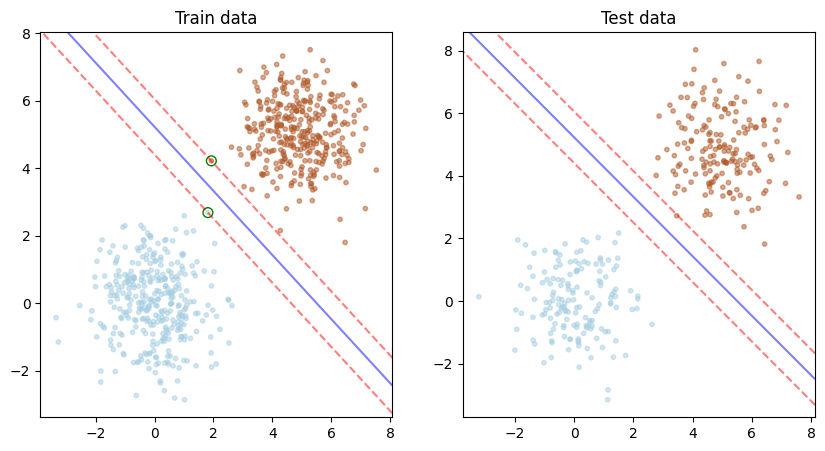

In [51]:
# illustrate decision for train and test data 
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
idx = np.where(y_train * decision_funct(X_train, w_smo, b_smo) < 0)[0]
visualSVM(X_train, y_train, w_smo, b_smo, sprt)
plt.title("Train data")

plt.subplot(1, 2, 2)
idx = np.where(y_test * decision_funct(X_test, w_smo, b_smo) < 0)[0]
visualSVM(X_test, y_test, w_smo, b_smo, idx)
plt.title("Test data")

plt.show()

Calculate accuracy of the given Dual SVM SMO method

In [52]:
# ========= YOUR CODE STARTS HERE ========= #
acc = (np.sum(y_test * decision_funct(X_test, w_smo, b_smo) > 0) / y_test.shape)[0]
print("The accuracy of dual SVM SMO is", acc)
# ========== YOUR CODE ENDS HERE ========== #

The accuracy of dual SVM SMO is 1.0


#### **Question 2.8 (0.25 pt): Wolfe duality summary**

Summarize in a few sequences how the dual Wolfe problem is used to find the optimal separation hyperplane and how it is solved using the SMO method

---
This is a summary of the steps taken to solve the dual Wolfe problem using the SMO method:
1. We start by defining the Lagrange function $\mathscr{L}(\mathbf{w}, b, \lambda)$ and its partial derivatives in $\mathbf{w}$ and $b$.
2. We then use these expressions in $\mathscr{L}$ to get the Wolfe dual problem of maximizing the quadratic problem $\mathscr{L}_D$ subject to the constraints $\lambda_j \ge 0$ and the slackness conditions that should be satisfied for every $j$.
3. We then apply the Sequential Minimal Optimization (SMO) method to solve the Wolfe dual problem. The idea is to update only two (randomly chosen) Lagrange multipliers a time, say $\lambda_i$ and $\lambda_j$, in such a way that the constraint condition $\sum_k \lambda_ky_k = 0$ is preserved, the updated lambda's are non-negative, and the value of the function increases. To this end, we calculate the partial derivatives of $\mathscr{L}$ in $\lambda_i$ and $\lambda_j$, form the partial gradient $\mathbf{g}_{i,j}$, and move along the constraint line $\ell = \lambda_i y_i + \lambda_j y_j = \mathrm{const}$ to increase the value of $\mathscr{L}_D$. If the direction vector $\mathbf{d}:=(y_j, -y_i)$ of $\ell$ forms an acute angle with $\mathbf{g}_{i,j}$, we update the two lambda's in that direction; otherwise, in the opposite. The simplest implementation uses a constant learning rate.

Wolfe dual problem replaces the calculation of the minimum in $q(\lambda)$ with the first order optimality condition for the minimum, which is often easier.



#### **Question 2.9 (up to 1.5 pt): Advanced SMO (Additional!)**

Think of some possible modifications to the given SMO algorithm (heuristics/another optimization approach). Provide detailed explanation for them, implement them and compare with the original SMO algorithm in terms of accuracy/efficiency

In [53]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #

## 3. Second task: Soft margin SVM classifier **(2 pts)**

For the purpose of this last part, we'll recreate overlapping red and blue blobs with `cluster_std = 2`

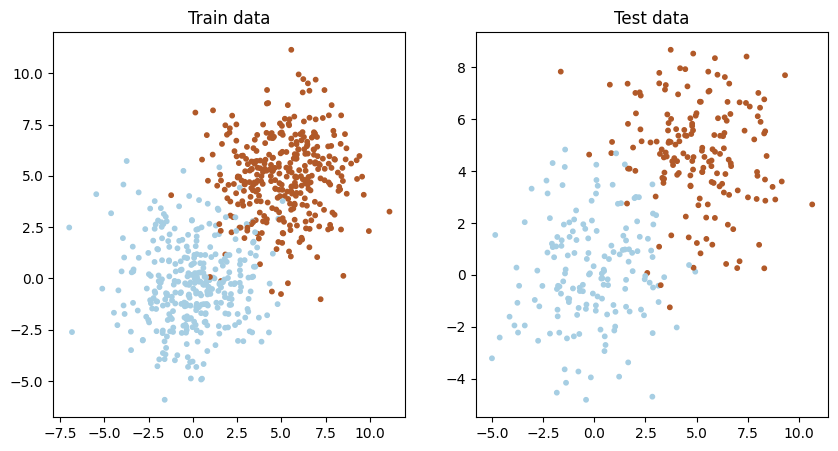

In [54]:
# generate data with cluster_std = 2
# ========= YOUR CODE STARTS HERE ========= #
cluster_std = 2
X_train, X_test, y_train, y_test = generate_data(num_samples_total, centers, num_features_for_samples, cluster_std)
red, blue, p = split_data(X_train, y_train)
# ========== YOUR CODE ENDS HERE ========== #
plot_data(X_train, X_test, y_train, y_test)

### 3.1 Slack variables and the objective function

In most situations, the classes are not linearly separable, i.e., there is no hyperplane separating red and blue points in $\mathbb{R}^n$ (cf. the simulated dataset with `cluster_std = 2`). In that case, we must accept that some training points will not be properly classified but try to keep their number low. Also, it is desirable to have a ''separating'' hyperplane with a relatively large margin ensuring robustness to noise. Thus our aim is to find a hyperplane $H$ and a margin $M = 1/\|\mathbf{w}\|$ such that almost all training observations are properly classified and are outside the slab of width $M$ aroung the hyperplane $H$ and the misclassification penalty is low.

To this end, we introduce the slack variables $\xi_j\ge0$ and impose relaxed  constraints
$$
  y_j[\mathbf{x}_j\cdot \mathbf{w} + b] \ge 1 - \xi_j. \tag{4}
$$
The slack variables
$$
  \xi_j = \max\{0, 1- y_j[\mathbf{x}_j \cdot \mathbf{w} + b]\}
$$
measure incorrectness of classification: $\xi_j = 0$ for correctly classified points outside the slab and $\xi_j >0$ for points that fall inside the slab or are in the wrong halfspace. The new objective function is
$$
  f(\mathbf{w},b,\xi_j) = \frac12\|\mathbf{w}\|^2 + C \sum_j \xi_j
$$
under the constraints (4); here $C$ is the cost constant penalizing misclassification. 


#### **Question 3.1 (0.25 pt): Constant $C$ effect**

Explain the effect that small and large cost constants $C$ should have on the solution. What happens when $C$ goes to infinity?

---
With larger $C$, we focus more on outliers and less on optimizing the margin, with the opposite being true for smaller $C$. When $C$ goes to infinity, we are effectively ignoring the margin and focusing only on minimizing the number of misclassified points.

### 3.2 Gradient descent **(1.75 pts)**

We rewrite the objective function as follows:
$$
    g(\mathbf{w},b) = \frac12 \|\mathbf{w}\|^2 + C \sum_{\xi_j>0}(1- y_j[\mathbf{x}_j \cdot \mathbf{w} + b])
$$
and apply the gradient descent method. The gradient is 
\begin{align*}
  \nabla_{\mathbf{w}} g & = \text{(mising formula)} \\
  \frac{\partial g}{\partial b} &= \text{(missing formula)}
\end{align*}
and the method updates the variables, 
$$
  (\mathbf{w}_{n+1}, b_{n+1})^\top = (\mathbf{w}_{n}, b_{n})^\top - \alpha \nabla g(\mathbf{w}_{n}, b_{n})
$$
until the stopping criterion is met.


#### Question 3.2 (0.5 pt): Gradient calculation

Calculate the gradient and plug in the formula below: 

---
$$
\begin{align*}
  \nabla_{\mathbf{w}} g & = w - C\sum_{\xi>0} y_jx_j \\
  \frac{\partial g}{\partial b} &=  - C\sum_{\xi>0} y_j
\end{align*}
$$

---

--- 
#### **Question 3.3 (1 pt)**  

*   Implement the functions below
---

In [55]:
# objective function
def g(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: np.float32, C: np.float32) -> np.float32:
  # ========= YOUR CODE STARTS HERE ========= #
  result = 1/2 * np.dot(w, w) + C * np.sum(np.maximum(0, 1 - y * (np.dot(X, w) + b)))
  # ========== YOUR CODE ENDS HERE ========== #
  return result


# gradient calculation
def grad_g(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: np.float32, C: np.float32) -> Tuple[np.ndarray, np.float32]:
  # ========= YOUR CODE STARTS HERE ========= #
  xi = 1 - y * (X @ w + b)
  grad_gw = w - C * np.sum((y * X.T).T[xi > 0], axis=0)
  grad_gb = -C * np.sum(y[xi > 0])
  # ========== YOUR CODE ENDS HERE ========== #
  return grad_gw, grad_gb


# gradient descent
def grad_desc_svm(X: np.ndarray, y: np.ndarray, C: np.float32, epsilon: float = 1e-4, n_steps: int = 10000, initial_lr: float = 1e-3) -> Tuple[np.ndarray, np.float32]:
  # ========= YOUR CODE STARTS HERE ========= #
  # initialization
  w = np.random.rand(X.shape[1])
  b = np.random.rand(1)

  # iteration
  step = 0
  lr = initial_lr
  while (step < n_steps):
    step += 1

    grad_gw, grad_gb = grad_g(X, y, w, b, C)
    # decrease lr if needed
    lr = lr if g(X, y, w - lr * grad_gw, b - lr * grad_gb, C) < g(X, y, w, b, C) else lr/2

    # update
    w -= lr * grad_gw
    b -= lr * grad_gb

  # ========== YOUR CODE ENDS HERE ========== #
  return w, b

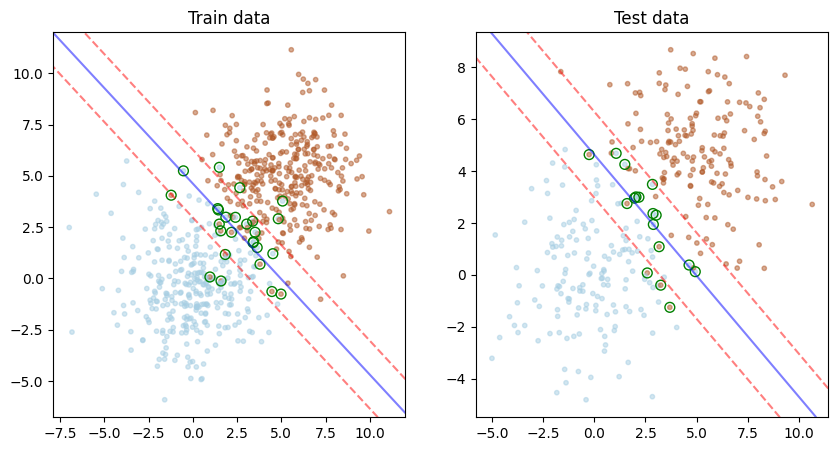

In [56]:
# run the gradient descent
w, b = grad_desc_svm(X_train, y_train, C=1)

# illustrate decision for train and test data 
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
idx = np.where(y_train * decision_funct(X_train, w, b) < 0)[0]
visualSVM(X_train, y_train, w, b, idx)
plt.title("Train data")

plt.subplot(1, 2, 2)
idx = np.where(y_test * decision_funct(X_test, w, b) < 0)[0]
visualSVM(X_test, y_test, w, b, idx)
plt.title("Test data")

plt.show()

Calculate accuracy of the Soft Margin SVM with gradient descent

In [57]:
# ========= YOUR CODE STARTS HERE ========= #
acc = np.sum(y_test * decision_funct(X_test, w, b) > 0) / y_test.shape
print("The accuracy of Soft Margin SVM with gradient descent is", acc)
# ========== YOUR CODE ENDS HERE ========== #

The accuracy of Soft Margin SVM with gradient descent is [0.94848485]


#### **Question 3.4 (0.25 pt): SVM via gradient descent summary**

Summarize in a few sequences how the optimal separating hyperplane can be found in non-separated case. Comment on the gradient descent method and its convergence. How does C affect the model?

---
Gradient descent is used to minimize the objective function $g(\mathbf{w},b)$, which is the sum of the margin and the penalty for misclassified points. The gradient is calculated and used to update the variables $(\mathbf{w}, b)$ until the stopping criterion is met. The cost constant $C$ affects the model by determining the trade-off between the margin and the penalty for misclassified points. A larger $C$ focuses more on minimizing the number of misclassified points, while a smaller $C$ focuses more on optimizing the margin.


## 4. Third task: nonlinear SVM **(1.5 pts)**

In this part, we'll implement the simplest version of the non-linear SVM, namely the one with the so-called polynomial kernel.



### 4.1 The main idea

In the case when the data are not linearly separable, we can try a nonlinear classifier function $f(\mathbf{x})$. For instance, if the red points are above the parabola $x_2 = x_1^2$ and all blue points are below it, then a natural candidate for the classifier is $f(\mathbf{x}) = -x_1^2 + x_2$.

For instance, with every $\mathbf{x} = (x_1,x_2)^\top$, we can consider the $6$-tuple 
$$
   \phi(\mathbf{x}) = (1, \sqrt2x_1, \sqrt2x_2, x_1^2, x_2^2, \sqrt2x_1x_2)^\top
$$
and the classifiying function 
$$
  f(\mathbf{x}) = \phi(\mathbf{x}) \cdot \mathbf{w} + b
$$
with $\mathbf{w} = (w_0, w_1, \dots, w_5)^\top$. 

#### 4.1.1 Soft margin classifier 

The soft margin approach with slack variables $\xi_j = \max\{0, 1- y_j \phi(\mathbf{x}_j) \cdot \mathbf{w}\}$ leads to the minimization of the objective function 
$$
   g(\mathbf{w}, \xi) = \frac12 \|\mathbf{w}\|^2 + C \sum_j \xi_j 
$$
under the constraints that, for each $j$,
$$
  \xi_j \ge 0  \quad \text{and} \quad 
  y_j [\phi(\mathbf{x}_j)\cdot \mathbf{w} + b] \ge 1 - \xi_j
$$

#### 4.1.2 Dual Wolfe problem

The dual problem leads to almost the same optimization problem as in the linear SVM, with the Lagrange function
$$
  \mathscr{L}(\mathbf{w}, b, \lambda, \eta) = \frac12\|\mathbf{w}\|^2 + C \sum_j \xi_j - \sum_j \lambda_j  \bigl(y_j [\phi(\mathbf{x}_j) \cdot \mathbf{w} + b] - (1 - \xi_j)\bigr) - \sum_j \eta_j \xi_j 
$$
Partial derivatives in $\mathbf{w}$, $b$, and $\xi$ give
$$
    \mathbf{w} = \sum_j \lambda_j y_j \phi(\mathbf{x}_j),
    \qquad
    0 = \sum_j \lambda_j y_j, 
    \qquad 
    \lambda_j = C - \eta_j \quad  (\le C) 
$$
using it in $\mathscr{L}$, we get the Wolfe dual problem of maximizing the quadratic problem
\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \phi(\mathbf{x}_j)\cdot\phi(\mathbf{x}_k) \tag{5}
\end{equation}
subject to the restrictions $0 \le \lambda_j \le C$ and $\sum_j \lambda_j y_j =0$. 

#### 4.1.3. The *kernel trick* 

The *kernel trick* is the observation that the coefficient matrix in (3) can be expressed through 
$$
  K(\mathbf{x}_j, \mathbf{x}_k) := \phi(\mathbf{x}_j)\cdot \phi(\mathbf{x}_k)  = 1 + 2\mathbf{x}_j\cdot\mathbf{x}_k + (\mathbf{x}_j\cdot\mathbf{x}_k)^2 = \bigl(1 + \mathbf{x}_j\cdot\mathbf{x}_k\bigr)^2
$$
In general, one can consider a polynomial kernel of order $d$:
$$
  K(\mathbf{x}_j, \mathbf{x}_k) = \bigl(1 + \mathbf{x}_j\cdot\mathbf{x}_k\bigr)^d
$$
or of many other forms. In terms of the kernel $K$, the Wolfe dual problem is to maximize 
$$
  \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, K(\mathbf{x}_j, \mathbf{x}_k)
$$
subject to $0 \le \lambda_j \le C$. This can be solved e.g. by the SMO method as above.


### 4.2 Implementation of quadratic SVM **(1.25 pts)**



--- 
#### **Question 4.1 (0.25 pt)**  

* Implement the functions below
---

In [58]:
# the embedding
def phi(x: np.ndarray) -> np.ndarray:
  # ========= YOUR CODE STARTS HERE ========= #
  x_embed = np.vstack([np.repeat(1, x.shape[0]), 2**0.5*x[:, 0], 2**0.5*x[:, 1], x[:, 0]**2, x[:, 1]**2, 2**0.5*x[:, 0]*x[:, 1]])
  x_embed = x_embed.T
  # ========== YOUR CODE ENDS HERE ========== #
  return x_embed


# embed all datapoints
def arr_phi(X: np.ndarray) -> np.ndarray:
  # ========= YOUR CODE STARTS HERE ========= #
  X_embed = phi(X)
  # ========== YOUR CODE ENDS HERE ========== #
  return X_embed


# the kernel
def K(x: np.ndarray, y: np.ndarray) -> np.float32:
  # ========= YOUR CODE STARTS HERE ========= #
  value = phi(x) @ phi(y)
  # ========== YOUR CODE ENDS HERE ========== #
  return value

--- 
#### **Question 4.2 (0.25 pt)**  

*   Implement the function below
---

In [59]:
def partial_kernel_derivative(X: np.ndarray, y:np.ndarray, lmbda: np.ndarray, j: int) -> np.float32:
  # ========= YOUR CODE STARTS HERE ========= #
  grad = 1 - np.sum(lmbda * y[j] * y * np.dot(phi(X), phi(X)[j]))
  # ========== YOUR CODE ENDS HERE ========== #
  return grad

--- 
#### **Question 4.3 (0.5 pt)**  

*   Modify the SMO function to solve the new dual Wolfe problem. Pay attention to the new inequality $\lambda_j \le C$ that the Lagrange multipliers must satisfy
---

In [60]:
def dualSVM_kernel_SMO(X: np.ndarray, y: np.ndarray, C: np.float32, lr: float = 1e-3, n_steps: int = 10000) -> np.ndarray:
  lmbda = np.zeros(X.shape[0])
  for k in range(n_steps):
    # ========= YOUR CODE STARTS HERE ========= #
    i, j = random.randint(0, X.shape[0]-1), random.randint(0, X.shape[0]-1)
    while y[i] == y[j]:
      j = random.randint(0, X.shape[0]-1)

    grad_i = partial_kernel_derivative(X, y, lmbda, i)
    grad_j = partial_kernel_derivative(X, y, lmbda, j)
    
    line_grad = np.fromiter([y[j], -y[i]], dtype=np.float64)
    part_grad = np.fromiter([grad_i, grad_j], dtype=np.float64)
    proj = np.dot(line_grad, part_grad) / np.linalg.norm(line_grad) ** 2 * line_grad

    if np.dot(part_grad, line_grad) < 0:
      proj = -proj

    lmbda_i = lmbda[i]
    lmbda_j = lmbda[j]
    lmbda[i] += lr * proj[0]
    lmbda[j] += lr * proj[1]

    if lmbda[i] < 0 or lmbda[j] < 0 or np.abs(np.dot(lmbda, y)) > 1e-3 or lmbda[i] > C or lmbda[j] > C:
      lmbda[i] = lmbda_i
      lmbda[j] = lmbda_j
      print("KKT constraint failed or lambda more than C")
    else:
      print(lmbda[i], lmbda[j])

  assert len(lmbda[lmbda <= C]) == len(lmbda)
    # ========== YOUR CODE ENDS HERE ========== #

  print("no. of steps:", k)
  assert len(lmbda[lmbda >= 0]) == len(lmbda)
  return lmbda

# run the quadratic SVM
lmbda = dualSVM_kernel_SMO(X_train, y_train, C=10)

0.0009999999999999998 0.0009999999999999998
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
0.0007813512759941301 0.0007813512759941301
0.0012861509945841876 0.0012861509945841876
0.0025341383535850545 0.0025341383535850545
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
0.007737270935781345 0.007737270935781345
KKT constraint failed or lambda more than C
0.0312961126195599 0.0312961126195599
0.096282356064481 0.096282356064481
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
0.3366467102356363 0.3366467102356363
KKT constraint failed or lambda more than C
0.9439073128422156 0.9439073128422156
0.8351879174316084 0.8351879174316084
3.181543949591531 3.181543949591531
KKT constraint failed or lambda more than C
KKT constraint failed or lambd

KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda more than C
KKT constraint failed or lambda 

--- 
#### **Question 4.4 (0.25 pt)**  

*   Determine the weights $w$ and $b$. For $w$, the formula is explicit; $b$ can be determined similarly to part 2 or in several other ways
---

In [61]:
# ========= YOUR CODE STARTS HERE ========= #
w_kernel_smo = lmbda*y_train@phi(X_train)
d, w_kernel_smo, b_kernel_smo, sprt = optimal_b(phi(X_train), y_train, w_kernel_smo)
# ========== YOUR CODE ENDS HERE ========== #

--- 
#### **Question 4.5 (0.25 pt)**  

*   Update the decision function for plotting and visualize the results 
---

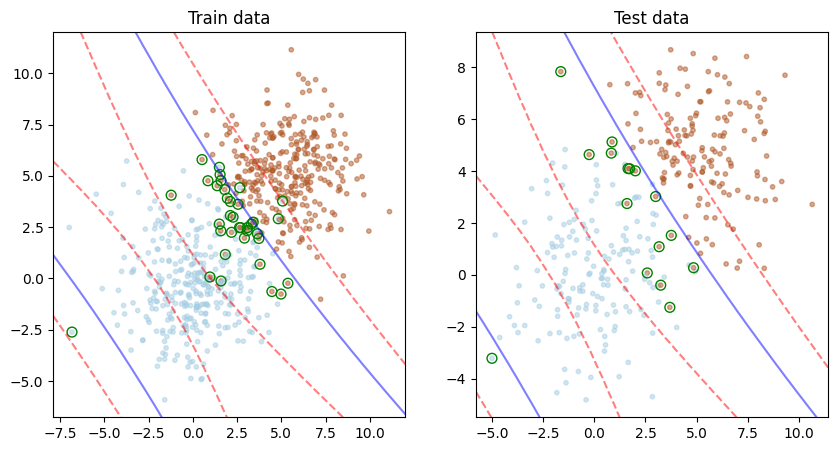

In [62]:
def decision_funct(x: np.ndarray, w: np.ndarray, b: np.float32) -> np.ndarray:
    # ========= YOUR CODE STARTS HERE ========= #
    value = -(phi(x) @ w + b)
    # ========== YOUR CODE ENDS HERE ========== #
    return value


# illustrate decision for train and test data 
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
idx = np.where(y_train * decision_funct(X_train, w_kernel_smo, b_kernel_smo) < 0)[0]
visualSVM(X_train, y_train, w_kernel_smo, b_kernel_smo, idx)
plt.title("Train data")

plt.subplot(1, 2, 2)
idx = np.where(y_test * decision_funct(X_test, w_kernel_smo, b_kernel_smo) < 0)[0]
visualSVM(X_test, y_test, w_kernel_smo, b_kernel_smo, idx)
plt.title("Test data")

plt.show()

Calculate accuracy of the Kernel-based classifier

In [63]:
# ========= YOUR CODE STARTS HERE ========= #
acc = np.sum(y_test * decision_funct(X_test, w_kernel_smo, b_kernel_smo) > 0) / y_test.shape
print("The accuracy of Kernel-based method is", acc)
# ========== YOUR CODE ENDS HERE ========== #

The accuracy of Kernel-based method is [0.95151515]


#### **Question 4.6 (up to 1.5 pt): Other Kernels (Additional!)**

Find information about other possible kernel functions (for example, RBF kernel). Provide detailed explanation of these kernel functions. Implement some of them, compare with the given polynomial kernel with d=2 in terms of accuracy/efficiency.

In [64]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #

## 5. Standard SVM implementation **(0.25 pt)**

Find out functionality of the `sklearn` built-in imlementation of the svm algorithm. Run it on the data to compare with your own implementation


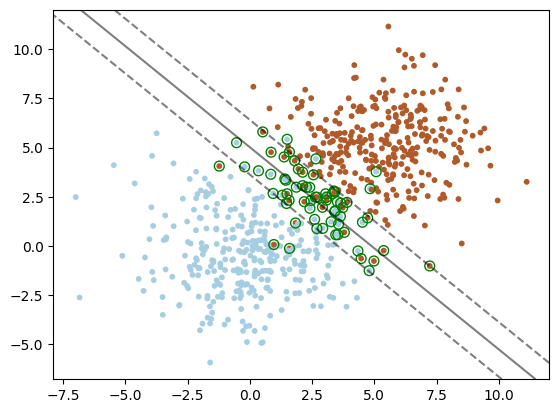

In [65]:
from sklearn import svm
# ========= YOUR CODE STARTS HERE ========= #
clf = svm.SVC(kernel='linear')
# ========== YOUR CODE ENDS HERE ========== #
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=50,
    linewidth=1,
    facecolors="none",
    edgecolors="g",
)
plt.show()

--- 
#### **Question 5.1 (0.25 pt)**  

Find out how to evaluate performance of nonlinear SVM classifier on the test data, and evaluate it

In [66]:
# Nonlinear SVM classifier evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# ========= YOUR CODE STARTS HERE ========= #
acc = accuracy_score(y_test, clf.predict(X_test))
f1 = f1_score(y_test, clf.predict(X_test))
# ========== YOUR CODE ENDS HERE ========== #
print(f"Accuracy of the model = {acc}, f1-score = {f1}")

Accuracy of the model = 0.9545454545454546, f1-score = 0.9557522123893806


## 6. Summary **(0.5 pts)**

---



Write a short report about the work you did.

Do not forget to discuss the following points:

*   a general idea of SVM classification;
*   difference between hard and soft margin approach;
*   SVM as an optimization task
*   how Wolfe dual problem allows to optimize implementation and sklearn, and reasons for that difference (if any)
*   complexity of the various approaches and algorithms
*   any difficulties you had completing the tasks



#### Question 6.1 (0.5 pts)  

SVM is an algorithm for finding the best hyperplane that separates two classes of points in $R^n$. It works by solving a constrained optimization problem, that involves maximizing the margin (thus, maximizing support vectors (two distances from the hyperplane to the closest point in each class), and thus minimizing $\frac{1}{2}w^2$ if we set $M = \frac{1}{w}$. The best part about the algorithm is that not only it finds a separating hyperplane, but it also maximizes the margin thus making the hyperplane more generalizable for the unseen data.

However there is an issue with unseparable classes. In that case we use "soft margin SVM" as opposed to "hard margin SVM". Its key idea is to add errors $\xi_i=\max{0, 1-y_i(x_i \cdot w_i + b)}$ to the objective function. The errors are non-zero only for the misclassified data points.

SVM maximizes the margin by setting it equal to $\frac{1}{w}$ and minimize $\frac{1}{2} w^2$ subject to $\qquad y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge 1$ i.e. subject to "all points are correctly classified" or $\qquad y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge 1 - \xi_i$ for soft margin case which is "points are classified so the classification error is minimal"

All algorithms (PLA, SMO, GD) were iterative i.e. with no solution in closed form. Our favorite was the gradient descent for the soft margin case, since it was the easiest to implement, but other methods converged as well.


## 7. Comments and suggestions to improve this lab assignment
 

--- 
#### **Question 7.1**  

We had no signifiant difficulties solving the lab and the materials enclosed were very nice. By the way, here is another explanation of SMO and alternative methods that we found useful: https://web.stanford.edu/group/SOL/reports/Ma-SMOvsPDCOforSVM.pdf

---